# Introduction

This heart disease classification project is centered around the critical task of diagnosing heart disease in individuals. Leveraging a comprehensive dataset with patient attributes.

Using powerful machine learning techniques, this project serves as a vital tool for healthcare professionals in making accurate heart disease diagnoses. It has the potential to significantly improve early detection and treatment, ultimately saving lives and enhancing the quality of patient care.

In [1]:
# Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

## Exploratory Data Analysis

In [2]:
# Read the data
data = pd.read_csv("heart_disease_classification.csv")
data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope   
0   63    1   3       145   233    1        0      150      0      2.3      0  \
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

We have several columns : 

- age : patient's age
- sex : patient's gender
- cp : patient's CP level
- trestbps : patient's Trest BPS level
- chol : patient's cholestrol level
- fbs : patient's FBS level
- restecg : patient's resting ECG level
- thalach : patient's thalach level
- exang : patient's exang level
- oldpeak : patient's old peak history recorded
- slope : patient's slope level
- ca : patient's ca level
- thal : patient's thal level
- target : 0 - heathly individual & 1 - heart disease patient

In [3]:
# Unique values of categorical features
for col in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']: 
    print(f"{col} -> {data[col].unique()}")

sex -> [1 0]
cp -> [3 2 1 0]
fbs -> [1 0]
restecg -> [0 1 2]
exang -> [0 1]
slope -> [0 2 1]
thal -> [1 2 3 0]
ca -> [0 2 1 3 4]


We will not apply OneHot encoding to these categorical features. Because the order of the level result matters and we don't want lose it. So we keep the numerical order of the values. 

In [4]:
# Columns information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


We have 14 columns, 13 int type columns and one decimal. It would seem we have no NaN in our dataset. 

In [5]:
# Percent of NaN values
data.isna().sum() / data.shape[0]

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

We have not NaN values in our dataset. 

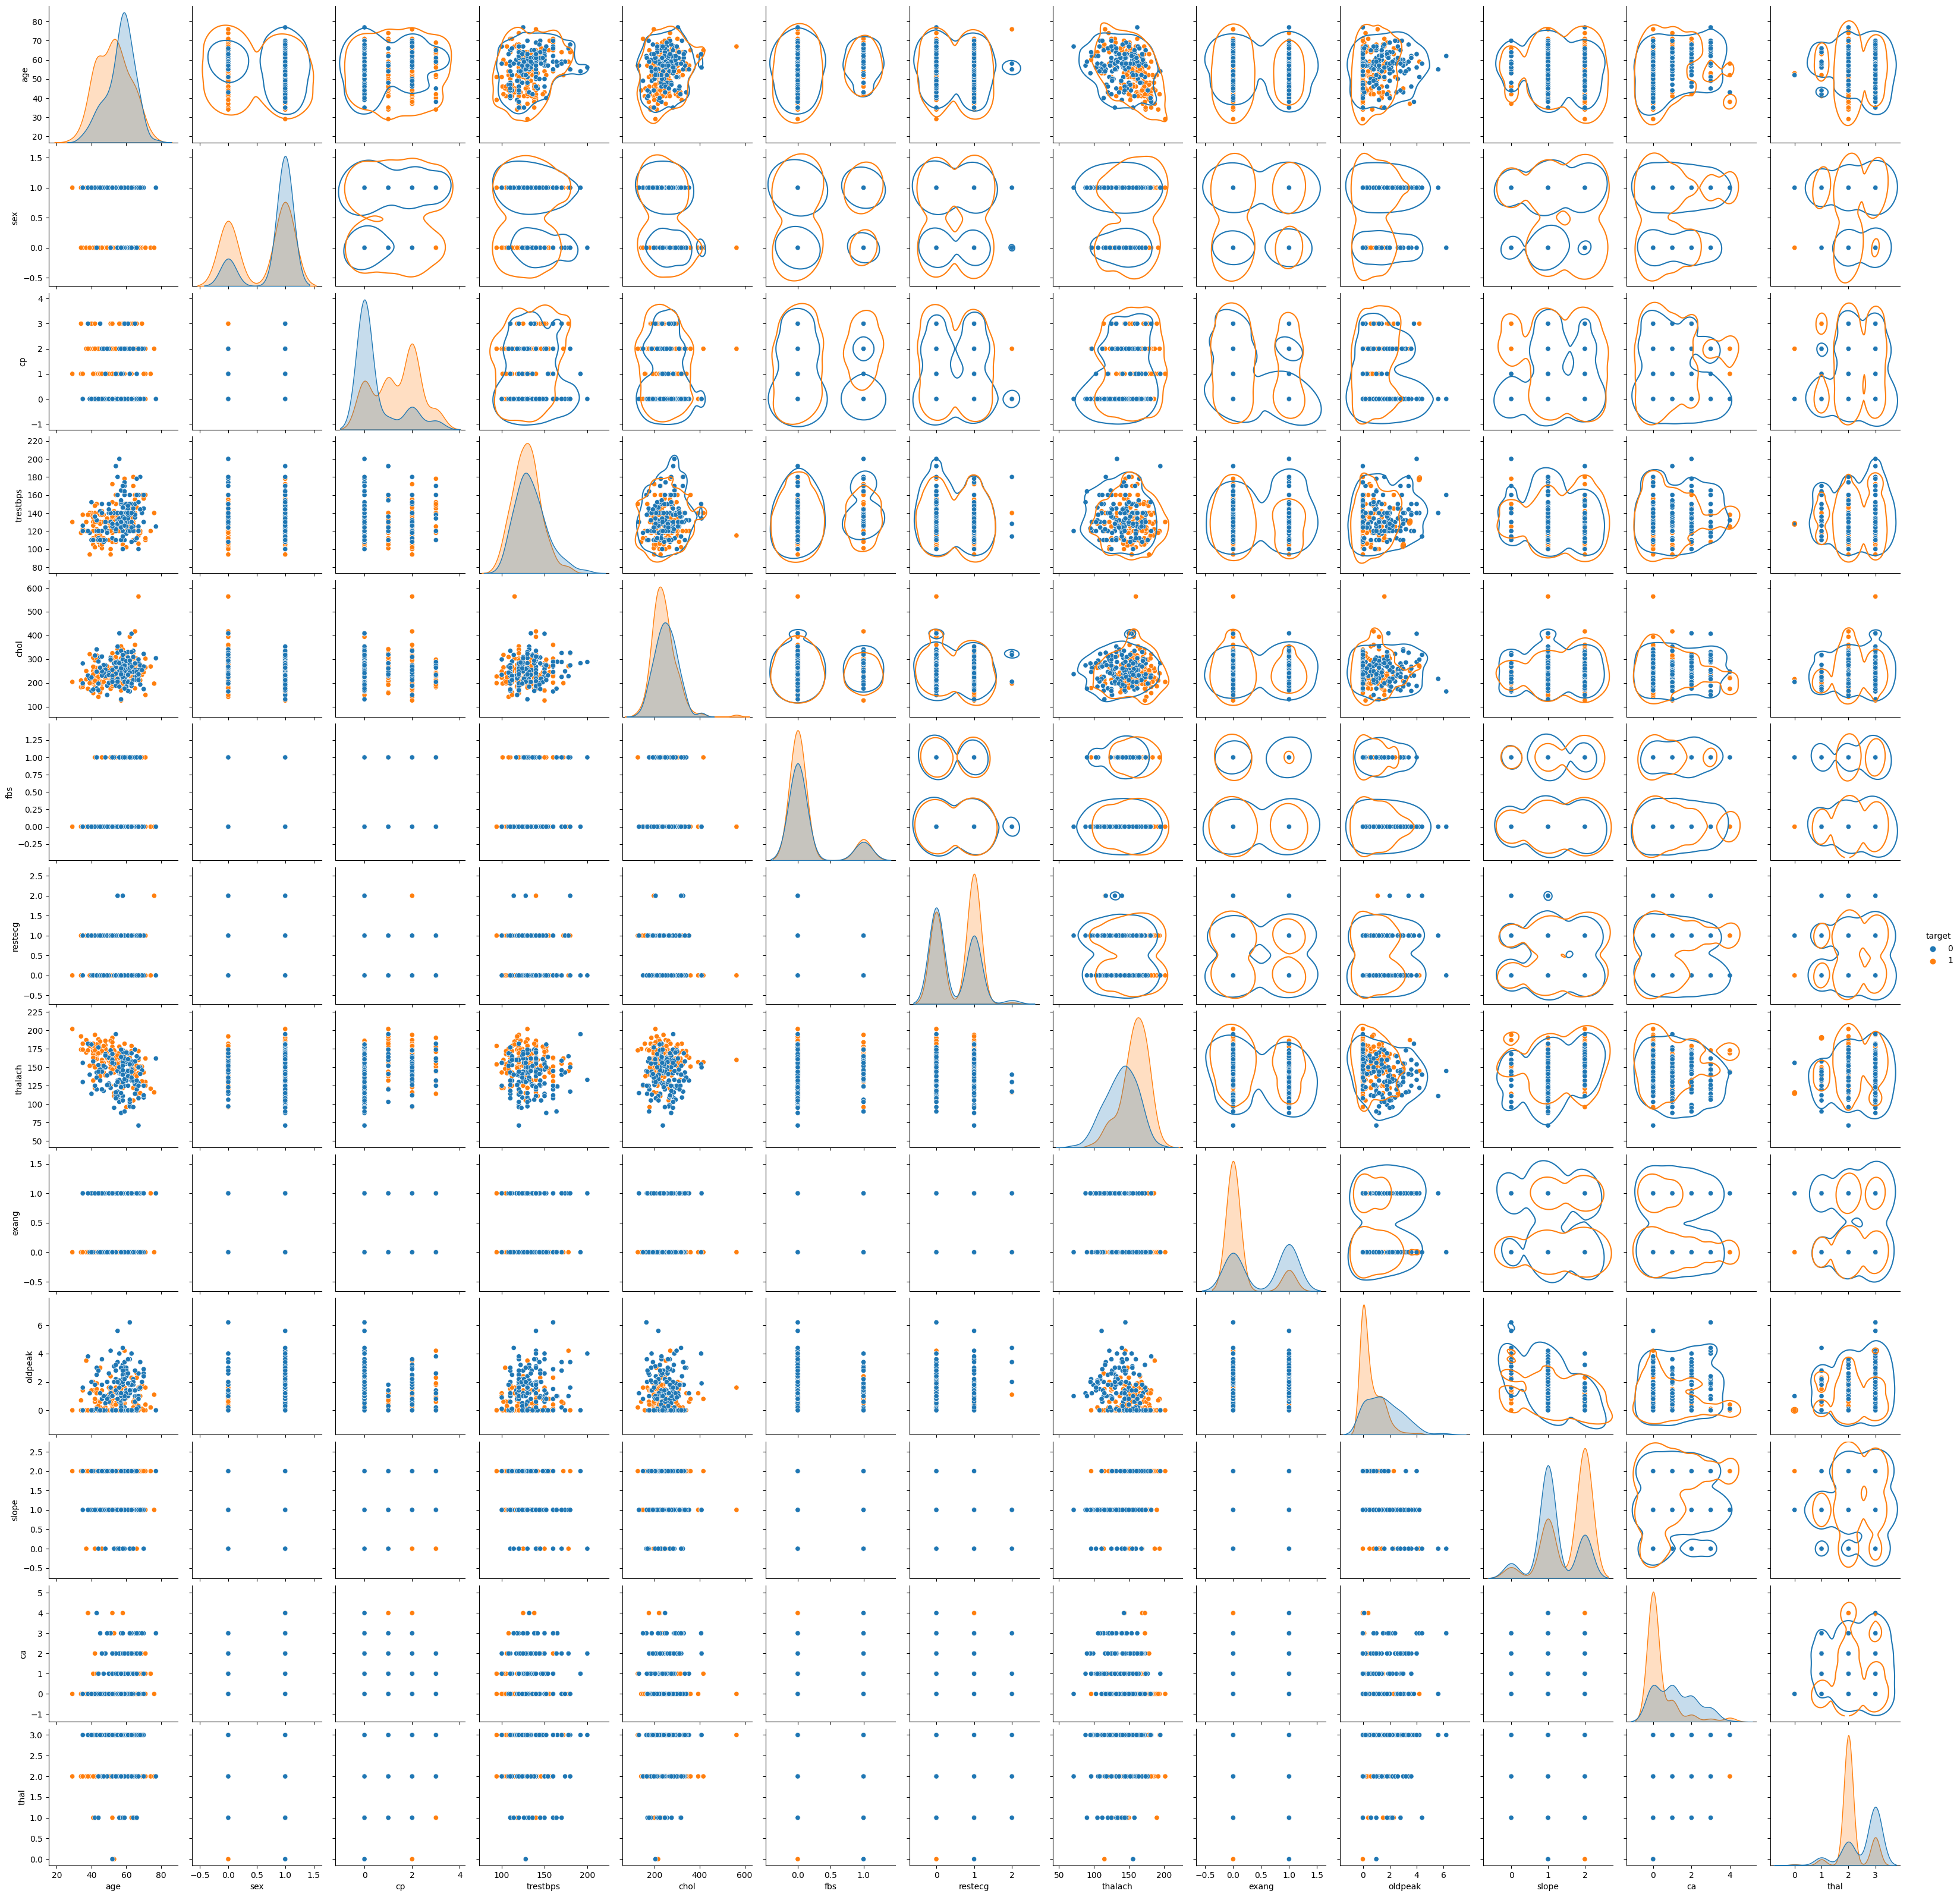

In [6]:
# Data distribution
sns.pairplot(data, hue='target').map_upper(sns.kdeplot, levels=2)
plt.show()

It seems that several features are correlated to our target, like thal, ca, slope, oldpeak, exang, cp, and may be thalach. It will be interested to see the correlation between features and their distribution using boxplot or violonplot. 

First, we can check the dataset target repartition.

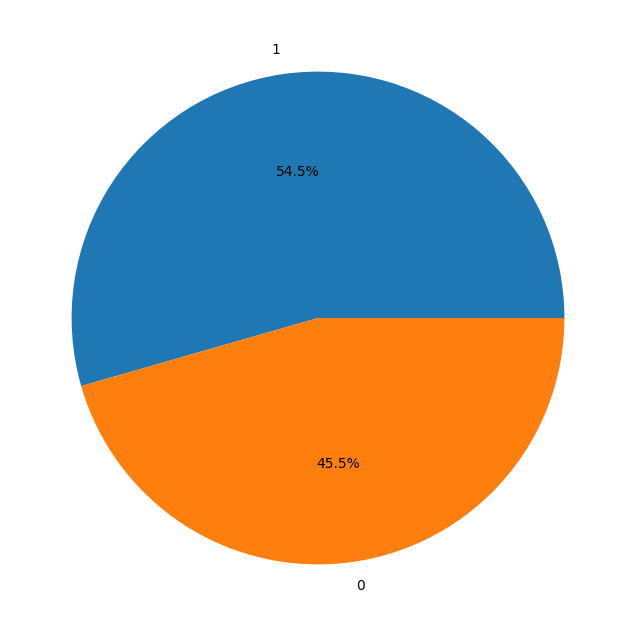

In [7]:
# Target balance
plt.figure(figsize=(12,8))
plt.pie(data['target'].value_counts(), labels=data['target'].unique(), autopct="%1.1f%%")
plt.show()

We can see that our two classe are balanced. So we should not use algorithm like SMOTE for imbalanced classification. It make easier our work.

Now, we are interested in the data distribution. Which is very important in machine learning. We use violon plot to see the features distribution on each target. The is show us which features can be important for a good classification. Moreover, it show us the outlier on our dataset. 

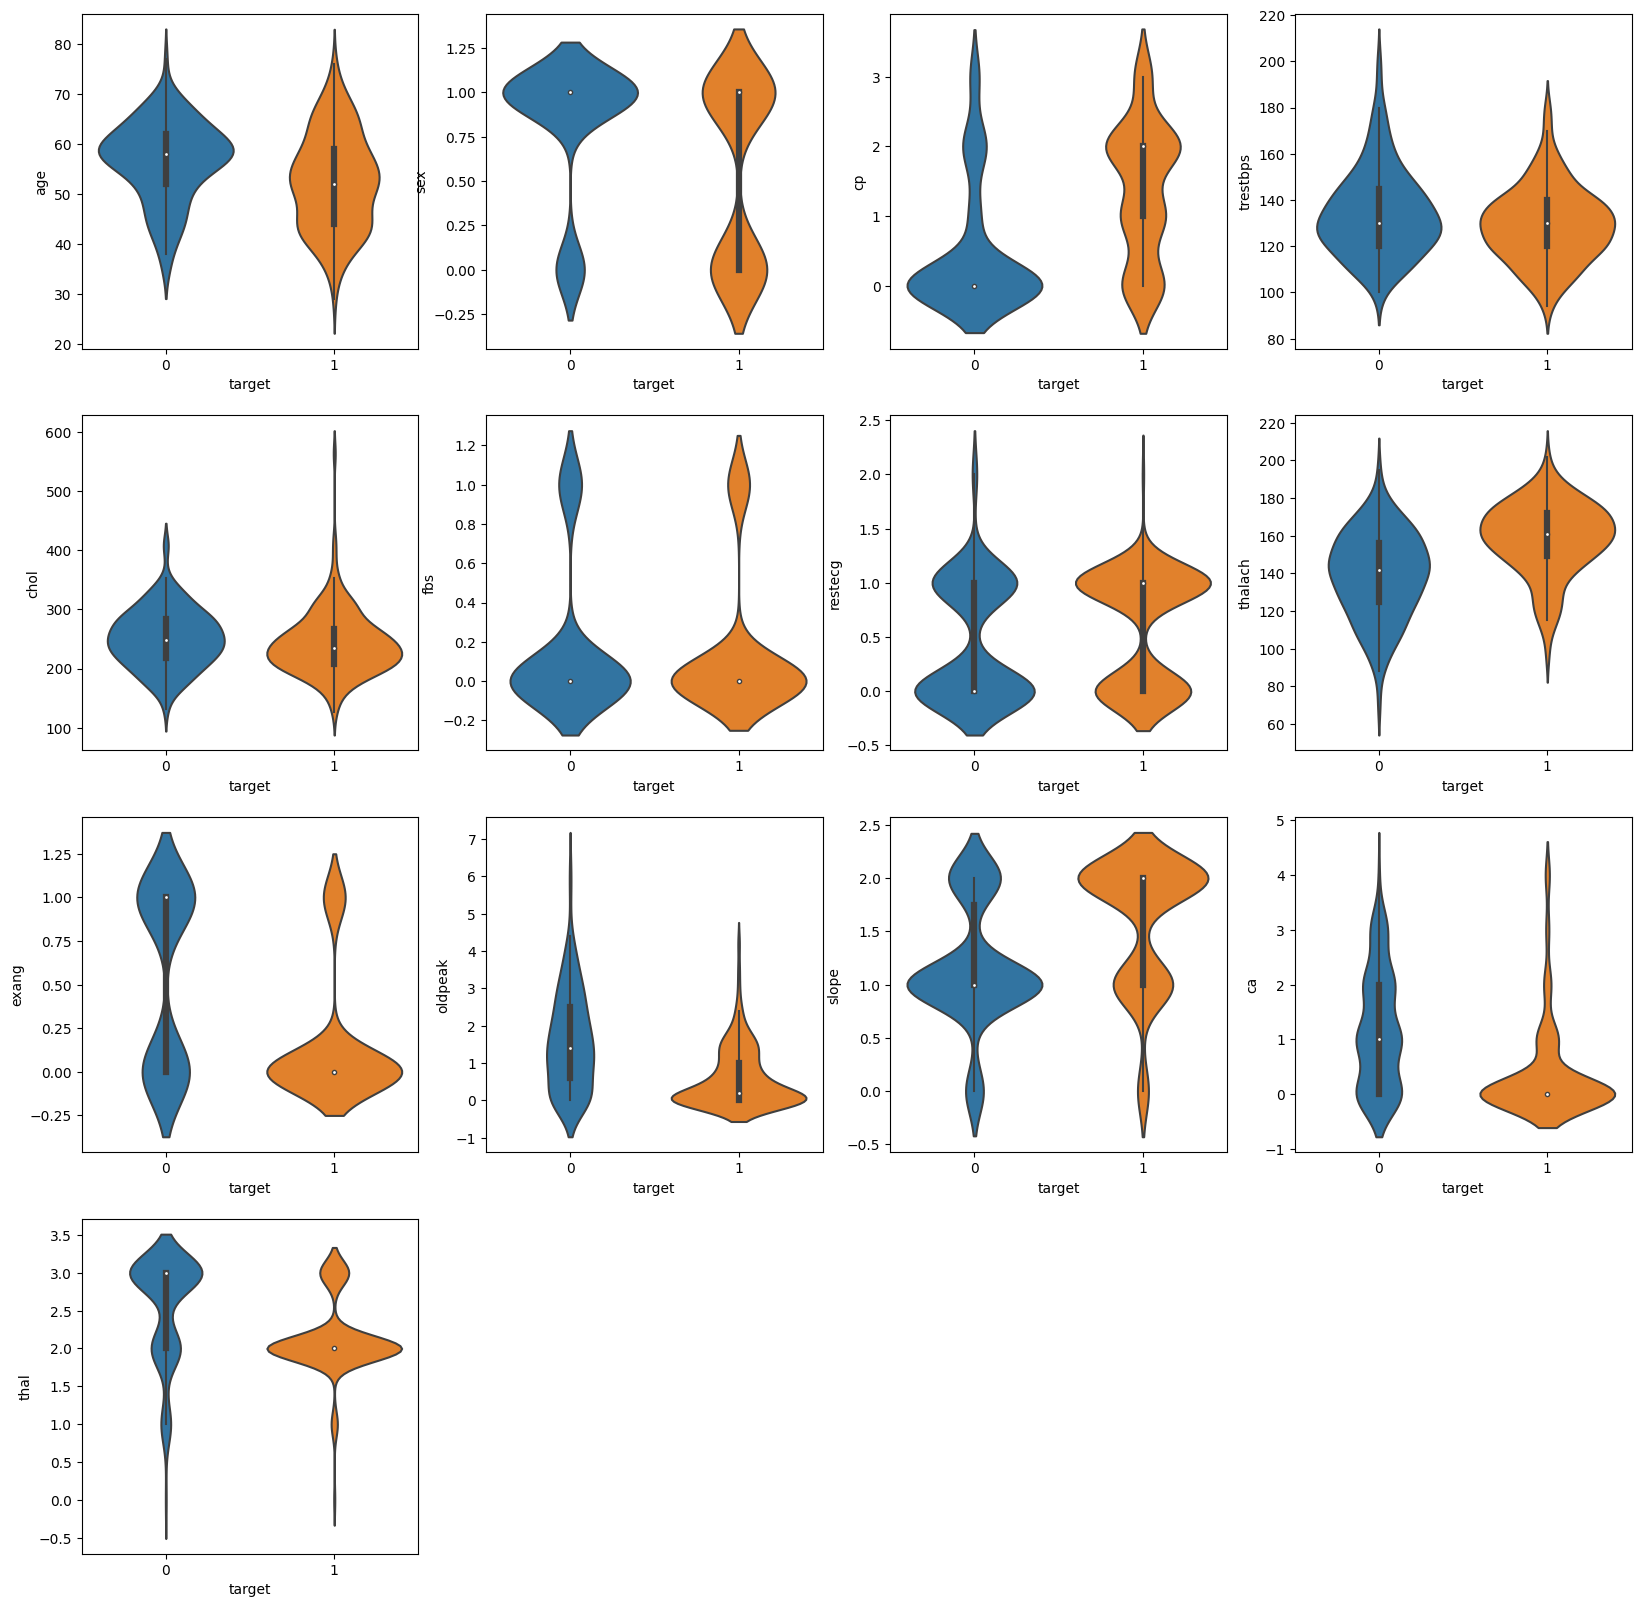

In [8]:
plt.figure(figsize=(20,20))
for index, col in enumerate(data.columns): 
    if col == "target": 
        continue
    plt.subplot(4, 4, index+1)
    sns.violinplot(x='target', y=col, data=data)
plt.show()

They are several features with a different distribution on the target. We can note : ca, slope, thal, cp, sex, exang. 

Another way to observe that is to use distribution histogram. Like this : 

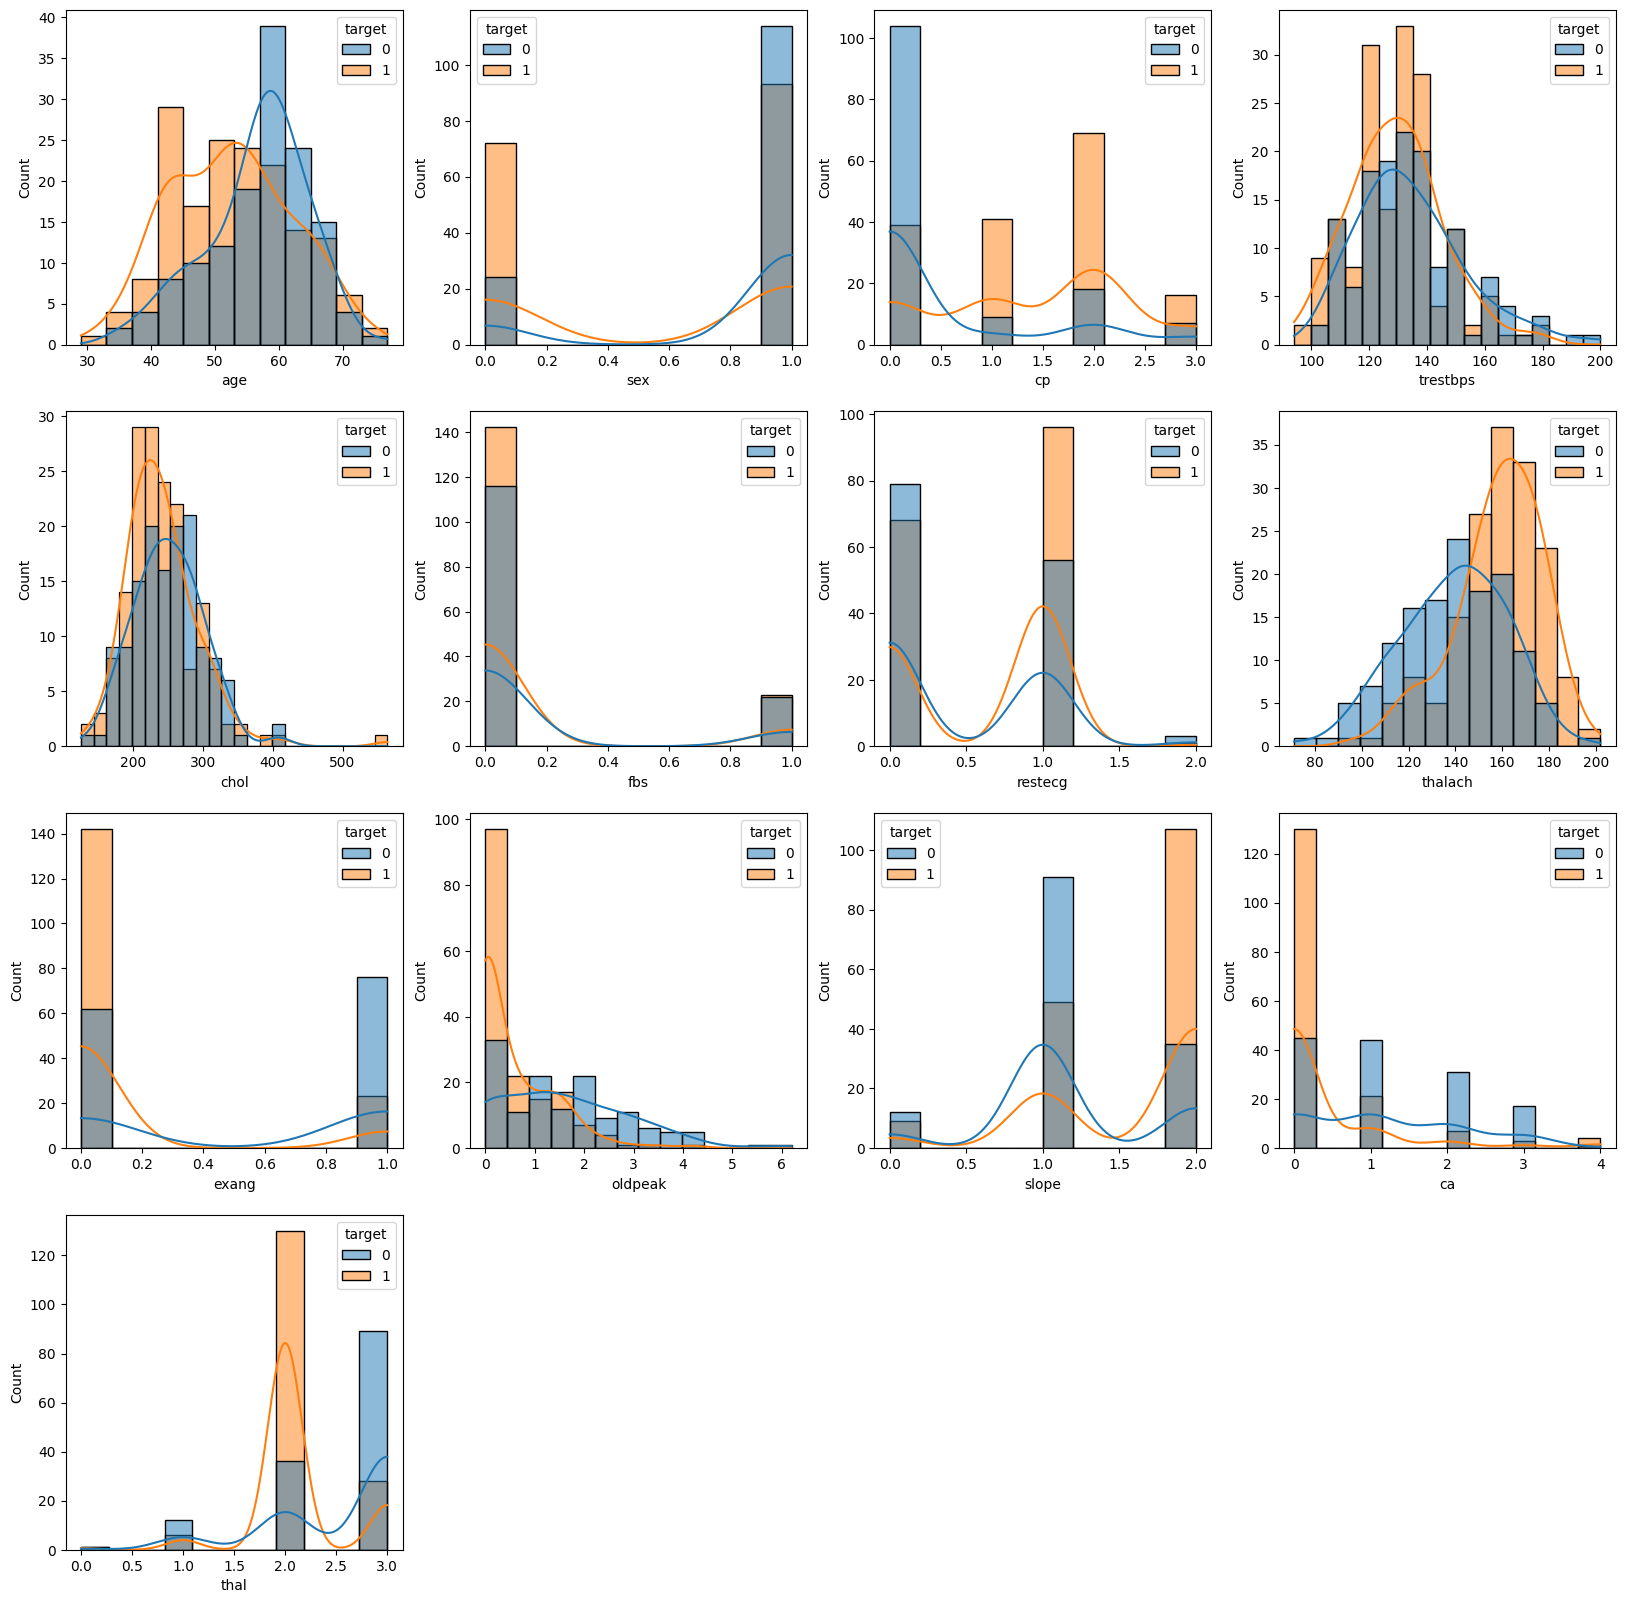

In [13]:
plt.figure(figsize=(20,20))
for index, col in enumerate(data.columns): 
    if col == "target": 
        continue
    plt.subplot(4, 4, index+1)
    sns.histplot(data=data, x=col, hue='target', kde=True)
plt.show()

It give us general information on the dataset, here, we think it will be difficult to have very high precision for our classification, because, even if we can see some differences between distribution on the target, our two classes seems to be mix together.

Now, we can observe the correlation between features. Indeed, we don't have a lot of samples, but a number of features quite important. So if we have strong correlation between features, it will be interesting to use some dimensional redcution. 

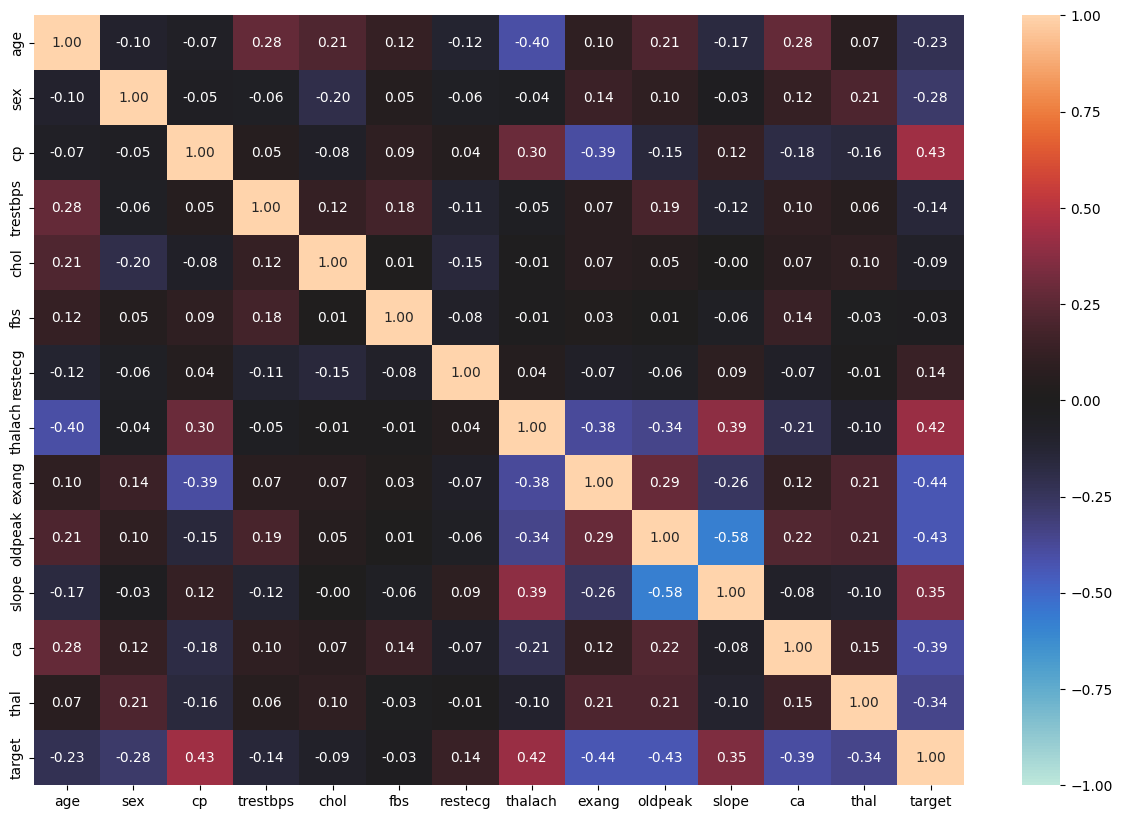

In [14]:
# Features correlation
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), vmax=1, vmin=-1, center=0, annot=True, fmt='.2f')
plt.show()

Unfortunately, we only have poor correlation. But it shows us that all features are important for the classification. 

## Preprocessing

We will build a machine learning model to predict our target. In order to improve on machine learning model and test them, we use a Support Vector Machine Classifier (SVC). SVC have the particularity to separate the two classes, but also to place the separator as far as possible from the closest instance. This is a wide margin classification. This is interesting in our case, because we want to be sure of the presence of the disease or not. 

But, first of all, we have to do some preprocessing on our dataset.

The first step is to normalise our data to avoid more significant features due to their bigger ranges of values. We only normalize numerical features and keep our categorical features.

In [21]:
#Separating target from features
X, y = data.drop('target', axis=1), data['target']
#Separate numeric values from categorical values
X_cat, X_num = (
    X[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']], 
    X[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]
)

# Standardization
Scaler = StandardScaler()
X_num = pd.DataFrame(Scaler.fit_transform(X_num), columns=X_num.columns)

# Concatenate in a single dataframe
X = pd.concat([X_num, X_cat], axis=1)
X

age  trestbps      chol   thalach   oldpeak  sex  cp  fbs  restecg   
0    0.952197  0.763956 -0.256334  0.015443  1.087338    1   3    1        0  \
1   -1.915313 -0.092738  0.072199  1.633471  2.122573    1   2    0        1   
2   -1.474158 -0.092738 -0.816773  0.977514  0.310912    0   1    0        0   
3    0.180175 -0.663867 -0.198357  1.239897 -0.206705    1   1    0        1   
4    0.290464 -0.663867  2.082050  0.583939 -0.379244    0   0    0        1   
..        ...       ...       ...       ...       ...  ...  ..  ...      ...   
298  0.290464  0.478391 -0.101730 -1.165281 -0.724323    0   0    0        1   
299 -1.033002 -1.234996  0.342756 -0.771706  0.138373    1   3    0        1   
300  1.503641  0.706843 -1.029353 -0.378132  2.036303    1   0    1        1   
301  0.290464 -0.092738 -2.227533 -1.515125  0.138373    1   0    0        1   
302  0.290464 -0.092738 -0.198357  1.064975 -0.896862    0   1    0        0   

     exang  slope  ca  thal  
0        0      0   0     1  
1        0      0   0     2  
2        0      2   0     2  
3        0      2   0     2  
4        1      2   0     2  
..     ...    ...  ..   ...  
298      1      1   0     3  
299      0      1   0     3  
300      0      1   2     3  
301      1      1   1     3  
302      0      1   1     2  

[303 rows x 13 columns]

The second step is to split our data in a trainset and testset (and obvioulsy split the target from inputs). This very important, our trainset will allow us to train the model and the testset to challenge its performances.

In [23]:
# Put in numpy array type 
X, y = X.values, y.values

# Split data in train and test set
(
    X_train, 
    X_test,
    y_train,
    y_test
) = train_test_split(X, y, train_size=0.70, random_state=42)

# Training shpae
print(X_train.shape)
print(y_train.shape)

(212, 13)
(212,)


Now, we define a SVM classifier. 

## Modeling

In [25]:
# Support Vector Machine Classifier (SVC) definition
model = SVC()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8131868131868132

We have a good precision with this model, but it can depend of the way we choose the trainset and the testset. And leads to overfitting.

To avoid this, we can use cross validation. It perform multiple split and ensure that each split will be use as train and test.
So our observation is based on the average of scores.

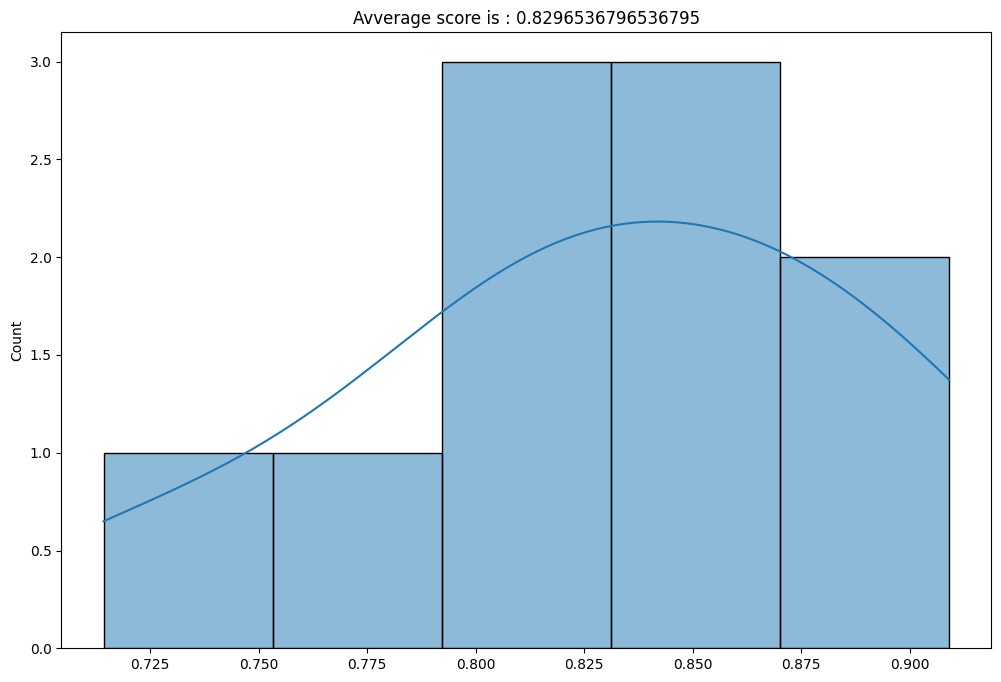

In [29]:
# Cross validation score 
cv_score = cross_val_score(model, X_train, y_train, cv=10)
plt.figure(figsize=(12,8))
sns.histplot(cv_score, kde=True)
plt.title(f"Avverage score is : {np.mean(cv_score)}")
plt.show()

This is quite good. Now we have the model average score whithout tune it. We can specify and test multiple parameters to improve our result. This is call optimization.

## Optimization

In [30]:
params = {
    "C": [0.1, 1, 10],
    "kernel": ['linear', 'rbf'],
    "gamma": ['scale', 'auto'],
    "class_weight": [None, 'balanced'],
}

grid_search = GridSearchCV(SVC(), param_grid=params, cv=10)
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

model = grid_search.best_estimator_

Best score: 0.8396103896103895
Best parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
Best estimator: SVC(C=1, kernel='linear')


In this case, it seems linear kernel is better than rbf. We define our SVM with theses parameters. 

And now we can visualize our result on a boxplot.

<Axes: xlabel='classifier', ylabel='accuracy'>

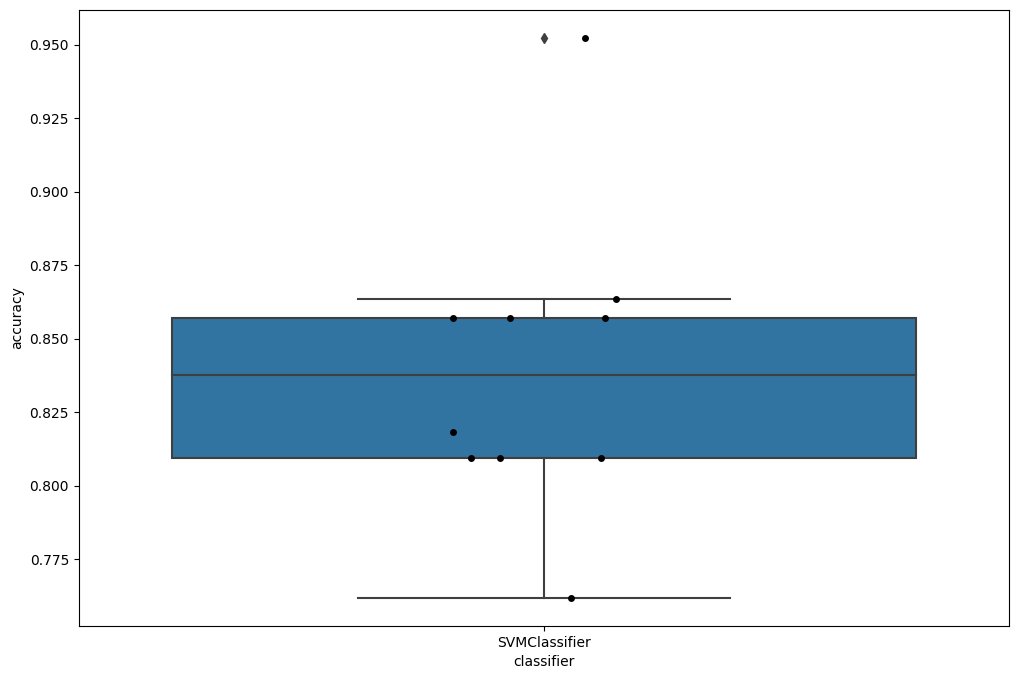

In [31]:
model_data = pd.DataFrame({
    'accuracy' : cross_val_score(model, X_train, y_train, cv=10), 
    'classifier' : ['SVMClassifier'] * 10
})

plt.figure(figsize=(12,8))
sns.boxplot(x='classifier', y='accuracy', data=model_data)
sns.stripplot(x='classifier', y='accuracy', data=model_data, jitter=True, color='black')

We can see the model precision range (with outlier). 

Another way to control the precision is the confusion matrix, it shows the number of True/False positive and True/False negative rates. 

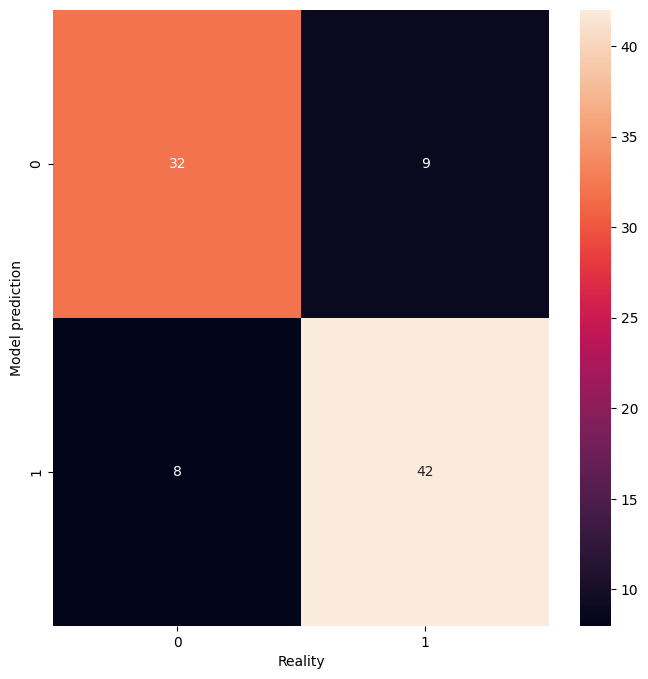

In [32]:
# Confusion matrix
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Reality")
plt.ylabel("Model prediction")
plt.show()

## Conclusion

We achieve good result using SVM model architecture. But a machine learning model needs more samples to improve its efficiency. In our case, we don't have enough data to improve our result, and it is a problem, because we dealing with heart disease which require high accuracy. 

So one solution could be to mine more data and train the model again.